# Part 6 - Google Trends data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

In this notebook I will describe my code to download data from Google trends 
as well as code to pull *keyword suggestions" based on some *seed* keywords.

I start in the usual way I do with all my notebooks with
* imports
* print version for Python and non standar modules

This boilerplate code is evolving and hopefully getting better

In [41]:
import os
import sys
import datetime
import inspect
import pandas as pd
import plotnine as pn
import pytrends as pt
from pytrends.request import TrendReq
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [43]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    mname = name
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        mname = name
        if hasattr(mod, "__path__"):
            mname = os.path.split(mod.__path__[0])[1]
        print("version {1} of {0} as {2} ".format(mname, name, mod.__version__))
    elif hasattr(mod, "__file__") and "site-packages" in mod.__file__:
        print("No __version__ for {0} as {1}".format(mname, name))
del mod
del name

version 3.9.2 of Python
version pd of pandas as 1.2.3 
version pn of plotnine as 0.7.1 
No __version__ for pt as pt
No __version__ for plt as plt
version mpl of matplotlib as 3.3.4 
version np of numpy as 1.20.1 


## Pytrends api
I'm new to pytrends but I'll make a go of using it.

Seems like the steps are
* create a *TrendReq* object which is usually called *pytrends*.
* configure the TrendReq object, called pytrends, by calling *build_payload* with pytrends with parameters for 
  - a keyword list
  - a timeframe
  - a geography reference
* call *interest_over_time* to get the data, returns a dataframe
 
It will be useful to wrap some of the code that sets up the paramaters for  ***build_payload*** into a function

I'll call the function *set_payload*

In [44]:
def set_payload(trend_req, kw_list, nweeks=100, geo='US', cat=60, grop=''):
    end_date = datetime.date.today()
    start_date = datetime.date.today() - datetime.timedelta(weeks=nweeks)
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    trend_req.build_payload(kw_list, cat=cat, timeframe=timeframe, geo=geo, gprop=grop)    
    return trend_req

In [45]:
tr = TrendReq(hl='en-US', tz=360)
tr = set_payload(trend_req=tr, kw_list=['work'], cat=60, nweeks=20, geo='US', grop='')
df = tr.interest_over_time()
print(df.head(2))
print(df.tail(2))

            work  isPartial
date                       
2020-12-16    80      False
2020-12-17    82      False
            work  isPartial
date                       
2021-05-02    53      False
2021-05-03    68      False


I don't know what *isPartial* means yet.  The module documentation does not say much about it.
I read somewere *You can ignore isPartial for now: that field lets you know if the data point is complete for that particular date*, so I plan to remove an ignore it.
Now let's try with more keywords and plot the results

<AxesSubplot:xlabel='date'>

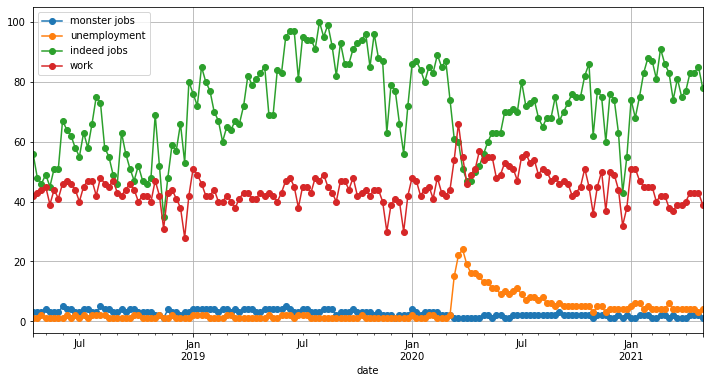

In [54]:
kw_list = [  "monster jobs",  "unemployment", "indeed jobs", "work"] #  "monster jobs"] #, "work"]
nweeks = 160
tr = set_payload(trend_req=tr, kw_list=kw_list, nweeks=nweeks, )
df = tr.interest_over_time().drop("isPartial", axis=1)
df.plot(figsize=[12,6], grid=True, marker='o')

Notes
* the resulting data is weekly. I have read that that is the standard when the time span is over 90 days.
* There is a *get_daily_data* method available in the pytrends module but I ok with weekly for now.


## Getting More keywords
OK, so far so good.  Maybe using more keywords would give us better preictor variables, but what other keywords might be useful.  The trend_requst object gives 2 methods that seem like they might help here
* relate_queries
* suggestions
I'm not sure the difference but for now I am usig related_queries.
It returns a *score* which I belive is some measure of how related the other query is.
Below I have some code to do the following
* start with some seed queries, push then into a queue
* pop an item off the queue, an item includes a keyword and a score
* if the score is above a threshold 
 - add the keyword to the keyword list
 - call *related queries* on the keyword and push all results above a cutoff into the queue

In [55]:
from collections import deque
import time

sleeptime = 0.0001
verbosity = 1
max_keywords = 100
min_score = 99

keywords2try = deque()
keyword_tups = deque()
keyword_set = set()

# seed the queue with a few terms
keywords2try.appendleft(("jobs", 101, 0, 'root', 101))
#keywords2try.appendleft(("unemployment", 101, 0, 'root', 101))
keywords2try.appendleft(("work", 101, 0, 'root', 101))
keywords2try.appendleft(("indeed jobs", 101, 0, 'root', 101))
print("Start {0}".format(datetime.datetime.now()))
while len(keywords2try) > 0:
    if len(keyword_tups) > max_keywords:
        break
    kw, score, level, parent, parent_score = keywords2try.pop()
    if kw in keyword_set:
        if verbosity > 1:
            print("{0} already in set".format(kw))
        continue
    if verbosity > 0:
        print("<kw#{1}='{0}''>, ".format(kw, len(keyword_tups)+1), end='')
    # add to keyword_tups and keyword_set
    keyword_tups.appendleft((kw, score, level, parent, parent_score))
    keyword_set.add(kw)
    
    trend_req = TrendReq(hl='en-US', tz=360)    
    trend_req = set_payload(trend_req, kw_list=[kw])
    # do I need to insert some wait time here?
    time.sleep(sleeptime)
    try:
        related = trend_req.related_queries()
    except Exception as e:
        last_exception = e
        exc_type, exc_obj, exc_tb = sys.exc_info()
        related = "error"
        break        
    if not related:
        if verbosity > 1:
            print("\t No related")
        continue
    if 'top' not in related[kw].keys():
        if verbosity > 1:
            print("\tNo top")
        continue
    df = related[kw]['top']
    if df is None:
        if verbosity > 1:
            print("\ttop is empty")
        continue
    for tup in df.itertuples():
        child_score = score * tup.value/float(100)
        if child_score > min_score and tup.query not in keyword_set:
            if verbosity > 1:
                print("\tpushing {0}".format(tup.query))
            keywords2try.appendleft((tup.query, child_score, level+1, kw, score))
if related == "error":
    import traceback
    traceback.print_tb(exc_tb)
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, fname, exc_tb.tb_lineno)  
    raise Exception(last_exception)
print("Done {0}".format(datetime.datetime.now()))
kw_df = pd.DataFrame(data=list(keyword_tups), columns=['keyword', 'score', 'level','parent', 'parent_score']).sort_values(by="score", ascending=False)
kw_df.sort_values(by='score', ascending=True)
kw_df.tail(20)

Start 2021-05-05 19:41:45.780846
<kw#1='jobs''>, <kw#2='work''>, <kw#3='indeed jobs''>, <kw#4='jobs near me''>, <kw#5='work from home''>, <kw#6='indeed jobs near me''>, <kw#7='hiring jobs near me''>, <kw#8='jobs work from home''>, <kw#9='indeed jobs hiring near me''>, <kw#10='jobs hiring near me part time''>, <kw#11='amazon work from home''>, <kw#12='work from home jobs amazon''>, <kw#13='places hiring near me''>, <kw#14='indeed resume''>, <kw#15='job hiring near me''>, <kw#16='work from home jobs''>, <kw#17='amazon jobs work from home near me''>, <kw#18='places hiring near me part time''>, <kw#19='indeed resume search''>, <kw#20='jobs near me hiring''>, <kw#21='part time jobs near me''>, <kw#22='jobs hiring part time near me''>, Done 2021-05-05 19:42:11.838574


,keyword,score,level,parent,parent_score
20,work,101.00,0,root,101.00
19,indeed jobs,101.00,0,root,101.00
18,jobs near me,101.00,1,jobs,101.00
17,work from home,101.00,1,work,101.00
16,indeed jobs near me,101.00,1,indeed jobs,101.00
15,hiring jobs near me,101.00,2,jobs near me,101.00
14,jobs work from home,101.00,2,work from home,101.00
13,indeed jobs hiring near me,101.00,2,indeed jobs near me,101.00
12,jobs hiring near me part time,101.00,3,hiring jobs near me,101.00
11,amazon work from home,101.00,3,jobs work from home,101.00


In [56]:
print("Found {0} queries".format(kw_df.shape[0]))
kw_df.sort_values(by="score", inplace=True)
out_dir = "./data"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
try:
    kw_df.to_csv(os.path.join(out_dir, "google_keywords.txt"))
except Exception as exc:
    print(exc)
    raise(exc)

Found 22 queries


In [57]:
trend_req = TrendReq(hl='en-US', tz=360)
nyears = 2
trends_df = pd.DataFrame()
for tup in kw_df.itertuples():
    kw_list = [tup.keyword]
    nweeks = 52*nyears
    trend_req = set_payload(trend_req, kw_list, nweeks=nweeks, )
    temp_df = trend_req.interest_over_time()
    temp_df.drop('isPartial', axis=1, inplace=True)
    if trends_df.shape[0] == 0:
        trends_df = temp_df
    else:
        trends_df = trends_df.join(temp_df)
print(trends_df.columns)

Index(['amazon jobs work from home near me', 'work from home jobs amazon',
       'jobs', 'jobs near me hiring', 'indeed resume search',
       'places hiring near me part time', 'work from home jobs',
       'job hiring near me', 'indeed resume', 'places hiring near me',
       'amazon work from home', 'jobs hiring part time near me',
       'jobs work from home', 'hiring jobs near me', 'indeed jobs near me',
       'work from home', 'jobs near me', 'indeed jobs', 'work',
       'part time jobs near me', 'indeed jobs hiring near me',
       'jobs hiring near me part time'],
      dtype='object')


In [58]:
trends_df.columns
trends_df.tail()

,amazon jobs work from home near me,work from home jobs amazon,jobs,jobs near me hiring,indeed resume search,places hiring near me part time,work from home jobs,job hiring near me,indeed resume,places hiring near me,...,jobs work from home,hiring jobs near me,indeed jobs near me,work from home,jobs near me,indeed jobs,work,part time jobs near me,indeed jobs hiring near me,jobs hiring near me part time
date,,,,,,,,,,,,,,,,,,,,,
2021-04-04,0,10,60,58,47,11,39,40,39,33,...,39,58,62,41,65,78,63,40,55,49
2021-04-11,0,10,63,54,35,11,43,43,33,55,...,43,54,56,37,65,85,68,54,66,44
2021-04-18,22,8,63,58,12,23,47,62,46,27,...,47,58,63,42,71,83,65,46,28,45
2021-04-25,11,14,62,63,12,34,46,39,28,41,...,46,63,76,44,70,87,67,53,45,57
2021-05-02,0,14,62,65,0,0,49,42,39,98,...,49,65,57,37,70,75,68,53,40,43


In [60]:
#trends_df.plot(figsize=(20, 10))
#plt.legend(loc='lower left')
#plt.show()

(6, 4)


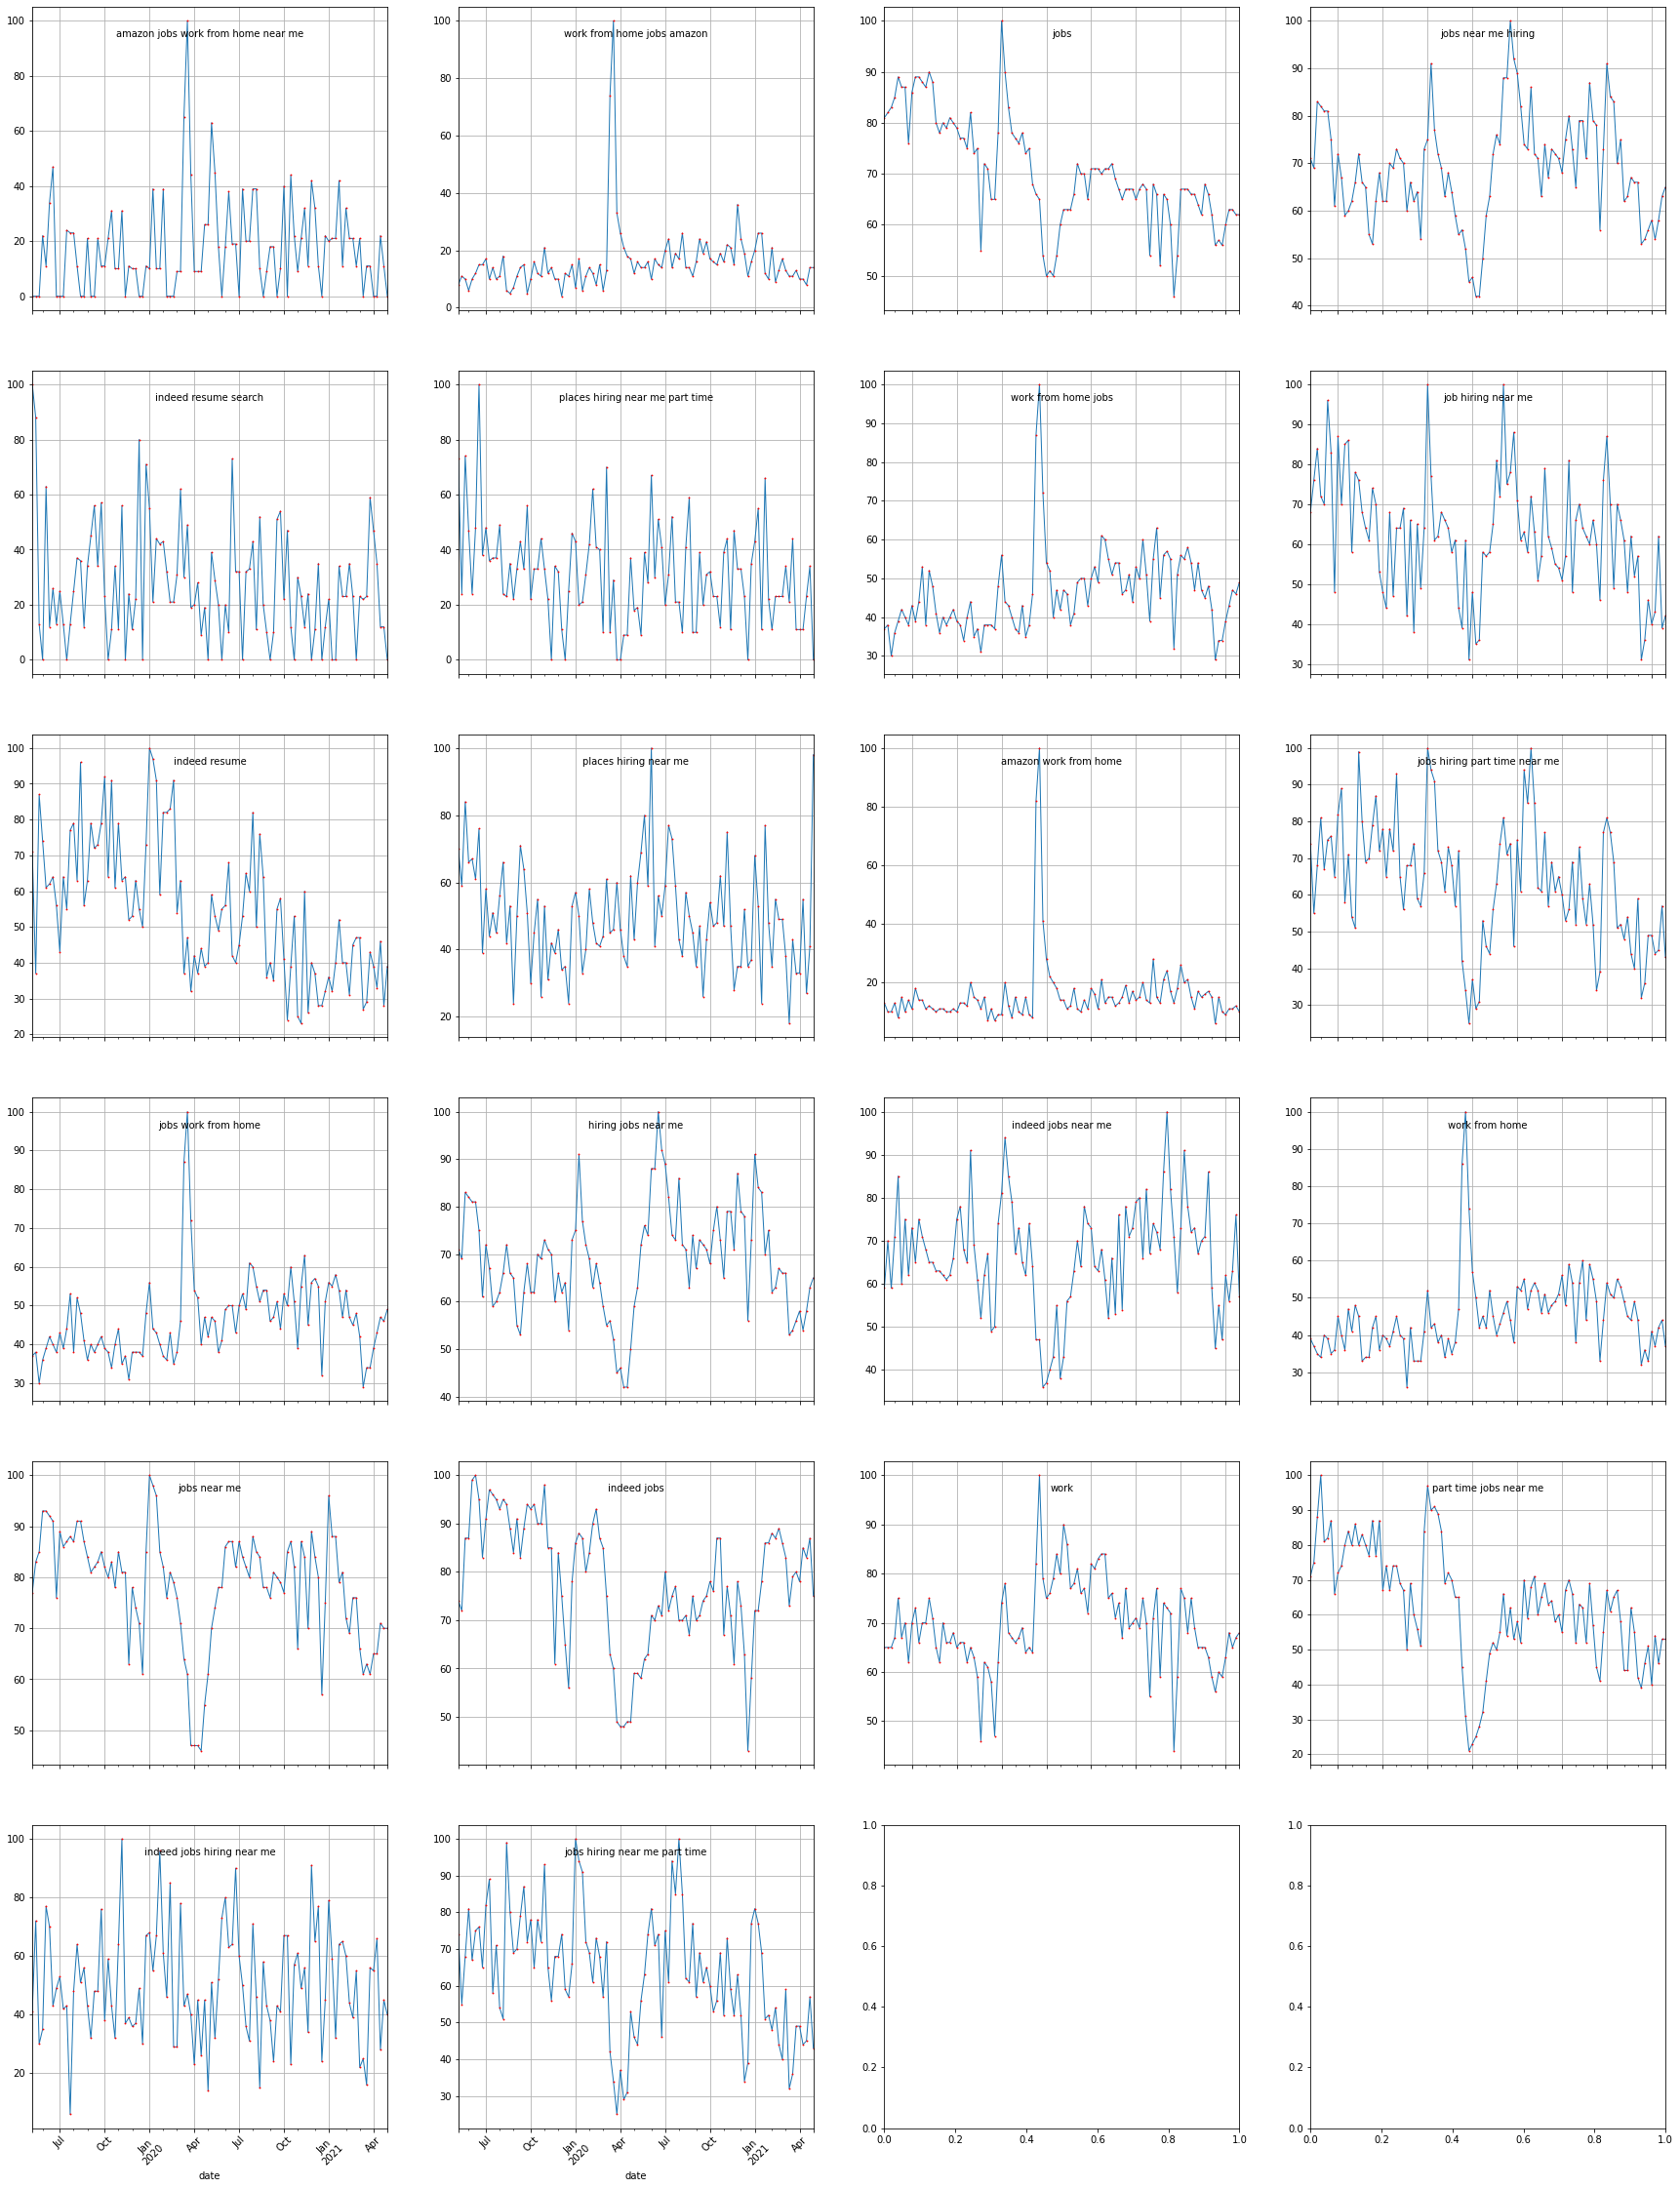

In [61]:
xcol = "date"
title = "title"
df = trends_df
#df.set_index("date", inplace=True)
ycols = [c for c in df.columns if c != "date"]
sharex = False
ncols=4
figwd=30
fight=40
xtick_rot = 45
ylim=(None, None)
nrows = int(np.ceil(len(ycols)/float(ncols)))
fig = None
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)  
print(axs.shape)
for i, ycol in enumerate(ycols):
  if ycol == "date":
    continue
  row = i // ncols
  col = i % ncols
  ax = axs[row][col]  
  #print(ycol)
  df["diff"]  = df[ycol].diff()
  df.iloc[-200:].plot(ax=ax, kind='line', y=ycol,linestyle='-', marker='o', lw=1, ylim=ylim,
                   mec='red', mfc='black', ms=0.85,  title=None, legend=None, label=None, grid=True, sharex=True)

  ax.text(.5,.9, ycol,
        horizontalalignment='center',
        transform=ax.transAxes)  
    
  ax.xaxis.set_tick_params(rotation=xtick_rot)     

plt.show()

In [62]:
print(trends_df.shape)
print(trends_df.head(2))
print(datetime.datetime.now())


(104, 23)
            amazon jobs work from home near me  work from home jobs amazon  \
date                                                                         
2019-05-12                                   0                           8   
2019-05-19                                   0                          11   

            jobs  jobs near me hiring  indeed resume search  \
date                                                          
2019-05-12    81                   71                   100   
2019-05-19    82                   69                    88   

            places hiring near me part time  work from home jobs  \
date                                                               
2019-05-12                               73                   37   
2019-05-19                               24                   38   

            job hiring near me  indeed resume  places hiring near me  ...  \
date                                                                  ... 

In [63]:
try:
    out_dir = "./data"
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    trends_df.sort_index()  
    trends_df.to_csv(os.path.join(out_dir, "google_trends.csv"))
except Exception as exc:
    print(exc)
    raise Exception(exc)

In [64]:
import datetime
print(datetime.datetime.now())

2021-05-05 19:43:14.619311
